In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

Text(0.5,1,'template')

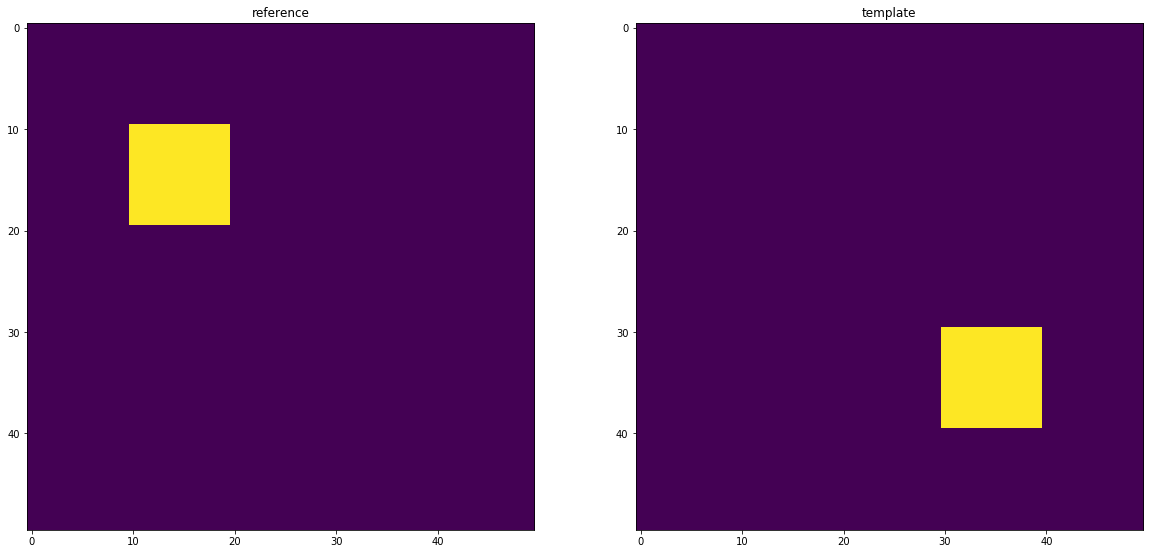

In [2]:
#define the reference image
reference = np.zeros((50, 50))
reference[10:20, 10:20] = 200

#define the template image
template = np.zeros_like(reference)
template[30:40, 30:40] = 200

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(reference)
ax0.set_title("reference")
ax1.imshow(template)
ax1.set_title("template")

In [3]:
def getGrid_r(M, N):
    #create the reference space [M, N, 3]
    grid_r = np.asarray(np.meshgrid(np.arange(M), np.arange(N), indexing = 'ij'))
    grid_r = np.rollaxis(grid_r, 0, 3)
    grid_r = np.concatenate((grid_r[:,:,0].reshape([M,N,1]), grid_r[:,:,1].reshape([M,N,1]), np.ones([M, N, 1])), axis = 2)
    # print(grid_r)
    return grid_r

In [4]:
def getTrans(trans_matrix, grid_r):
    #create the rigid transformation
    rg_trans = grid_r.dot(trans_matrix.T)
    rg_trans = np.split(rg_trans, [2], axis=2)[0]
    print(rg_trans.shape)
    # print(rg_trans[2][1])
    return rg_trans

In [5]:
def getCoordinate(rg_trans):
    #split the rg_transformation
    y1_rg, y2_rg = np.split(rg_trans,[1], axis=2)
    # y1_rg,y2 _rg shape = (M, N)
    y1_rg = y1_rg.squeeze()
    y2_rg = y2_rg.squeeze()
    # crate the floor, ceil coordinate
    y1_floor = np.floor(y1_rg).astype(int)
    y1_ceil = np.floor(y1_rg+1).astype(int)
    y2_floor = np.floor(y2_rg).astype(int)
    y2_ceil = np.floor(y2_rg+1).astype(int)

    floor_ceil = [y1_floor, y1_ceil, y2_floor, y2_ceil]
    y1_y2_rg = [y1_rg, y2_rg]
    #temp_00_coor -> (y1_floor, y2_floor)
    #temp_10_coor -> (y1_ceil, y2_floor)
    #temp_01_coor -> (y1_floor, y2_ceil)
    #temp_11_coor -> (y1_ceil, y2_ceil)
    return floor_ceil, y1_y2_rg

In [6]:
def bilinear(floor_ceil, y1_y2_rg, template):
    [y1_rg, y2_rg] = y1_y2_rg
    [y1_floor, y1_ceil, y2_floor, y2_ceil] = floor_ceil
    temp_00 = map_template(y1_floor, y2_floor, template)
    temp_10 = map_template(y1_ceil, y2_floor, template)
    temp_01 = map_template(y1_floor, y2_ceil, template)
    temp_11 = map_template(y1_ceil, y2_ceil, template)
    temp = [temp_00, temp_10, temp_01, temp_11]
#     xr1 = (x1_rg-x1_floor)
#     xr2 = x2_rg-x2_floor
#     gen_image = (y_ceil-y_rg) * ((x_ceil - x_rg) * temp_00 + (x_rg - x_floor) * temp_01)\
#                 + (y_rg - y_floor) * ((x_ceil - x_rg) * temp_10 + (x_rg - x_floor) * temp_11)
    gen_image = (1-(y1_rg-y1_floor)) * ((1-(y2_rg-y2_floor)) * temp_00 + (y2_rg - y2_floor) * temp_01)\
                + (y1_rg - y1_floor) * ((1-(y2_rg-y2_floor)) * temp_10 + (y2_rg - y2_floor) * temp_11)
    dT = getDerivation_Y1Y2(floor_ceil, y1_y2_rg, temp)
    return gen_image, dT

In [7]:
def map_template(y1_coor, y2_coor, template):
    #flat坐标空间，y*N+x
    flat = (y1_coor*N + y2_coor).reshape((M*N,))
    #将不再坐标范围内的点标记为0
    flat[flat>=M*N] = 0
    flat[flat<0] = 0
    #根据展开的坐标得到转换后的图片
    new = np.take(template, flat).reshape((M, N))
    #查找rg_trans中不再坐标范围内的点
    y1_del_mul = (y1_coor>=0)*(y1_coor<M)
    y2_del_mul = (y2_coor>=0)*(y2_coor<N)
#     print(x_del_mul)
    #将rg_trans中不再坐标空间内的点的值设置为0
    new = new * y1_del_mul * y2_del_mul
    return new

In [8]:
def getDerivation_Y1Y2(floor_ceil, y1_y2_rg, temp):
    [y1_rg, y2_rg] = y1_y2_rg
    [temp_00, temp_10, temp_01, temp_11] = temp
    [y1_floor, y1_ceil, y2_floor, y2_ceil] = floor_ceil
    #     yr1 = y1_rg-y1_floor
    #     yr2 = y2_rg-y2_floor
    dTdy1 = (1 - (y2_rg-y2_floor)) * (temp_10 - temp_00) + (y2_rg-y2_floor) * (temp_11 - temp_01)
    dTdy2 = (1 - (y1_rg-y1_floor)) * (temp_01 - temp_00) + (y1_rg-y1_floor) * (temp_11 - temp_10)
    return [dTdy1, dTdy2]

In [29]:
def getCost(reference, gen_image):
    return np.sum(np.power(gen_image - reference, 2))/2

In [19]:
def computeGradient(reference, gen_image, dT, grid_r):
    [dTdy1, dTdy2]  =dT
    grid_x1, grid_x2, _ = np.split(grid_r, [1,2], axis=2)
    grid_x1 = grid_x1.squeeze()
    grid_x2 = grid_x2.squeeze()
    
    print(np.sum(np.abs(dTdy1)))

    dw1 = np.sum((gen_image - reference) * dTdy1 * grid_x1)
    dw2 = np.sum((gen_image - reference) * dTdy1 * grid_x2)
    dw3 = np.sum((gen_image - reference) * dTdy1)
    
    dw4 = np.sum((gen_image - reference) * dTdy2 * grid_x1)
    dw5 = np.sum((gen_image - reference) * dTdy2 * grid_x2)
    dw6 = np.sum((gen_image - reference) * dTdy2)
    
    dw = [dw1, dw2, dw3, dw4, dw5, dw6]
    return dw

In [20]:
#initialize the grid size MxN, M->X, N->Y
M=50
N=50
#initialize the transformation matrix [3, 3]
# y1 -> trans_matrix[0]
# y2 -> trans_matrix[1]
trans_matrix = np.array([[1,0.5,10], [0,1,10], [0,0,1]])

(50, 50, 2)
4000.0
cost is 3950000.0
Gradient is 
[-4400000.0, -4800000.0, -200000.0, -9400000.0, -18240000.0, -760000.0]


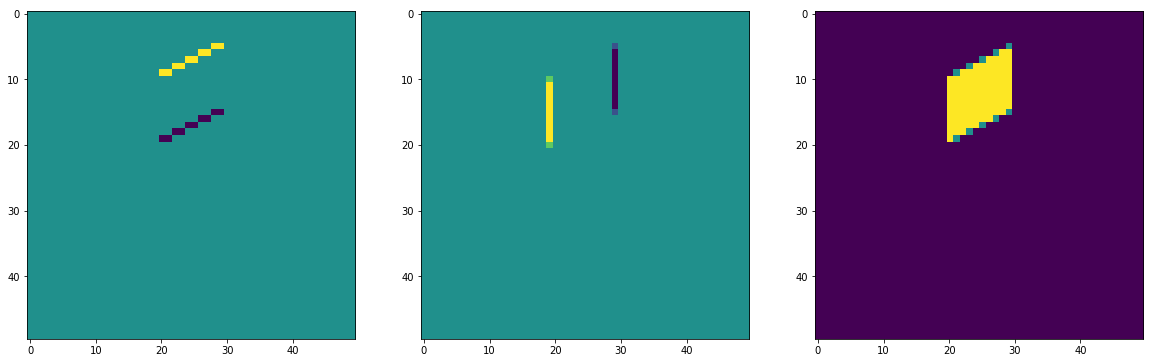

In [30]:
grid_r = getGrid_r(M, N)
rg_trans = getTrans(trans_matrix, grid_r)
floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
cost = getCost(reference, gen_image)
gradient = computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r)
print("cost is " + str(cost))
print("Gradient is ")
print(gradient)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(dT[0])
ax1.imshow(dT[1])
ax2.imshow(gen_image)

In [47]:
def testGradient(M, N, trans_matrix, e):
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost = getCost(reference, gen_image)
    gradient = computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r)
    
    trans_matrix_ = np.array([[1+e,0.5,10], [0,1,10], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_1 = getCost(reference, gen_image)
    
    trans_matrix_ = np.array([[1,0.5+e,10], [0,1,10], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_2 = getCost(reference, gen_image)
    
    trans_matrix_ = np.array([[1,0.5,10+e], [0,1,10], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_3 = getCost(reference, gen_image)
    
    trans_matrix_ = np.array([[1,0.5,10], [0+e,1,10], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_4 = getCost(reference, gen_image)
    
    trans_matrix_ = np.array([[1,0.5,10], [0,1+e,10], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_5 = getCost(reference, gen_image)
    
    trans_matrix_ = np.array([[1,0.5,10], [0,1,10+e], [0,0,1]])
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix_, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template)
    cost_6 = getCost(reference, gen_image)
    
    nu_dw1 = (cost_1 - cost) / e
    nu_dw2 = (cost_2 - cost) / e
    nu_dw3 = (cost_3 - cost) / e
    nu_dw4 = (cost_4 - cost) / e
    nu_dw5 = (cost_5 - cost) / e
    nu_dw6 = (cost_6 - cost) / e
    
    nu_gradient = np.array([nu_dw1, nu_dw2, nu_dw3, nu_dw4, nu_dw5, nu_dw6])
    error_ratio = (nu_gradient - gradient) / gradient
    
    print("derivative gradient is ")
    print(gradient)
    print('\n')
    print("numerical gradient is ")
    print(nu_gradient)
    print('\n')
    print("error ratio is ")
    print(error_ratio)

In [51]:
trans_matrix = np.array([[1,0,10], [0,1,10], [0,0,1]])
testGradient(M, N, trans_matrix, e = 1e-3)

(50, 50, 2)
4000.0
(50, 50, 2)
(50, 50, 2)
(50, 50, 2)
(50, 50, 2)
(50, 50, 2)
(50, 50, 2)
derivative gradient is 
[-11600000.0, -9800000.0, -400000.0, -9800000.0, -11600000.0, -400000.0]


numerical gradient is 
[-54331599.99999963 -54556599.99999916 -50199599.99999963
 -59335349.99999963 -68011619.99999824 -50759619.99999825]


error ratio is 
[  3.68375862   4.567      124.499        5.05462755   4.86307069
 125.89905   ]
